In [1]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Compose
set_default_plot_size(40cm, 14cm)

home = "/home/german/labo/18/egfr/rg/"
home_gram = "/home/german/labo/18/egfr/renonmis_gram/"
home_modos = "/home/german/labo/18/egfr/modos/"
home_rtdos = "/home/german/labo/18/egfr/rtdos_log/"
aa = 277

277

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# Rg

In [4]:
# Leo nombres de structuras
tmp = readdlm(string(home_gram, "pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(string(home_gram, "am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(string(home_gram, "im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

# Leo modos de SVD
svd_im_1 = readdlm(string(home_rtdos, "svd_im_1"))
svd_im_2 = readdlm(string(home_rtdos, "svd_im_2"))

svd_am_1 = readdlm(string(home_rtdos, "svd_am_1"))
svd_am_2 = readdlm(string(home_rtdos, "svd_am_2"));

In [13]:
# Leo todos los residuos de pocket
tmp = readdlm(string(home_gram, "nonmis_aa_pocket"))
aa_pocket = convert(Array{Int64, 1}, reshape(tmp, length(tmp)))

aa_pocket_nonmis = length(aa_pocket)
aa_3_pocket_nonmis = aa_pocket_nonmis * 3

aa_pocket_3 = Array{Int64}(aa_3_pocket_nonmis)
for i = 1:aa_pocket_nonmis
    aa_pocket_3[3*i - 2] = aa_pocket[i] * 3 - 2
    aa_pocket_3[3*i - 1] = aa_pocket[i] * 3 - 1
    aa_pocket_3[3*i] = aa_pocket[i] * 3
end

# Leo modos modelo
modos_1m14 = readdlm(string(home_modos, "1M14_A/modos_1M14_A"))[:, 1:825]
modos_3w32 = readdlm(string(home_modos, "3W32_A/modos_3W32_A"))[:, 1:825];

## Leo autovectores de los grammianos

In [19]:
# IM
ncombs_im =  length(im_list) * (length(im_list) - 1)
im_1 = Array{Float64, 2}(aa_36, ncombs_im)
im_2 = Array{Float64, 2}(aa_36, ncombs_im)
im_3 = Array{Float64, 2}(aa_36, ncombs_im)
im_4 = Array{Float64, 2}(aa_36, ncombs_im)
im_5 = Array{Float64, 2}(aa_36, ncombs_im)
k = 0

for each in im_list
    for cada in im_list
        if each == cada
           continue
        end
        k += 1
        tmp = readdlm(string(home, "eigenvectors/", each, "/uno_", each, "_", cada))
        im_1[:, k] = reshape(tmp, length(tmp))

        tmp = readdlm(string(home, "eigenvectors/", each, "/dos_", each, "_", cada))
        im_2[:, k] = reshape(tmp, length(tmp))

        tmp = readdlm(string(home, "eigenvectors/", each, "/tre_", each, "_", cada))
        im_3[:, k] = reshape(tmp, length(tmp))

        tmp = readdlm(string(home, "eigenvectors/", each, "/cua_", each, "_", cada))
        im_4[:, k] = reshape(tmp, length(tmp))

        tmp = readdlm(string(home, "eigenvectors/", each, "/cin_", each, "_", cada))
        im_5[:, k] = reshape(tmp, length(tmp))
    end
end

In [17]:
# AM
ncombs_am =  length(am_list) * (length(am_list) - 1)
am_1 = Array{Float64, 2}(aa_36, ncombs_am)
am_2 = Array{Float64, 2}(aa_36, ncombs_am)
am_3 = Array{Float64, 2}(aa_36, ncombs_am)
am_4 = Array{Float64, 2}(aa_36, ncombs_am)
am_5 = Array{Float64, 2}(aa_36, ncombs_am)
k = 0

for each in am_list
    for cada in am_list
        if each == cada
           continue 
        end
        k += 1
        tmp = readdlm(string(home, "eigenvectors/", each, "/uno_", each, "_", cada))
        am_1[:, k] = reshape(tmp, length(tmp))
        
        tmp = readdlm(string(home, "eigenvectors/", each, "/dos_", each, "_", cada))
        am_2[:, k] = reshape(tmp, length(tmp))
        
        tmp = readdlm(string(home, "eigenvectors/", each, "/tre_", each, "_", cada))
        am_3[:, k] = reshape(tmp, length(tmp))
        
        tmp = readdlm(string(home, "eigenvectors/", each, "/cua_", each, "_", cada))
        am_4[:, k] = reshape(tmp, length(tmp))
        
        tmp = readdlm(string(home, "eigenvectors/", each, "/cin_", each, "_", cada))
        am_5[:, k] = reshape(tmp, length(tmp))
    end
end

## Obtengo  SVDs

In [27]:
# IM
u_im_1, s_im_1, v_im_1 = svd(im_1)
u_im_2, s_im_2, v_im_2 = svd(im_2)
u_im_3, s_im_3, v_im_3 = svd(im_3)
u_im_4, s_im_4, v_im_4 = svd(im_4)
u_im_5, s_im_5, v_im_5 = svd(im_5)

# AM
u_am_1, s_am_1, v_am_1 = svd(am_1)
u_am_2, s_am_2, v_am_2 = svd(am_2)
u_am_3, s_am_3, v_am_3 = svd(am_3)
u_am_4, s_am_4, v_am_4 = svd(am_4)
u_am_5, s_am_5, v_am_5 = svd(am_5);

## Obtengo modos svd1/2/3/4/5 según struct modelo inactiva(3W32_A) y activa(1M14_A)

In [ ]:
# IM
svd_im_1 = modos_3w32 * u_im_1[:, 1]
svd_im_2 = modos_3w32 * u_im_2[:, 1]
svd_im_3 = modos_3w32 * u_im_3[:, 1]
svd_im_4 = modos_3w32 * u_im_4[:, 1]
svd_im_5 = modos_3w32 * u_im_5[:, 1]

# AM
svd_am_1 = modos_1m14 * u_am_1[:, 1]
svd_am_2 = modos_1m14 * u_am_2[:, 1]
svd_am_3 = modos_1m14 * u_am_3[:, 1]
svd_am_4 = modos_1m14 * u_am_4[:, 1]
svd_am_5 = modos_1m14 * u_am_5[:, 1];

## Leo modos 1, 2, 3, 4  y 5 de todas las structs

In [63]:
# IM
modos_im_1 = Array{Float64, 2}(aa_3, length(im_list))
modos_im_2 = Array{Float64, 2}(aa_3, length(im_list))
modos_im_3 = Array{Float64, 2}(aa_3, length(im_list))
modos_im_4 = Array{Float64, 2}(aa_3, length(im_list))
modos_im_5 = Array{Float64, 2}(aa_3, length(im_list))

k = 0
for each in im_list
    k += 1
    tmp = readdlm(string(modos_home, each, "/modos_", each));
    
    modos_im_1[:, k] = tmp[:, 1]
    modos_im_2[:, k] = tmp[:, 2]
    modos_im_3[:, k] = tmp[:, 3]
    modos_im_4[:, k] = tmp[:, 4]
    modos_im_5[:, k] = tmp[:, 5]
end

# AM
modos_am_1 = Array{Float64, 2}(aa_3, length(am_list))
modos_am_2 = Array{Float64, 2}(aa_3, length(am_list))
modos_am_3 = Array{Float64, 2}(aa_3, length(am_list))
modos_am_4 = Array{Float64, 2}(aa_3, length(am_list))
modos_am_5 = Array{Float64, 2}(aa_3, length(am_list))

k = 0
for each in am_list
    k += 1
    tmp = readdlm(string(modos_home, each, "/modos_", each));
    
    modos_am_1[:, k] = tmp[:, 1]
    modos_am_2[:, k] = tmp[:, 2]
    modos_am_3[:, k] = tmp[:, 3]
    modos_am_4[:, k] = tmp[:, 4]
    modos_am_5[:, k] = tmp[:, 5]
end

## Obtengo pdtos escalares entre los modos SVD y los modos originales de las structs

In [64]:
# AM
dots_svd_am_1 = Array{Float64, 1}(length(am_list))
dots_svd_am_2 = Array{Float64, 1}(length(am_list))
dots_svd_am_3 = Array{Float64, 1}(length(am_list))
dots_svd_am_4 = Array{Float64, 1}(length(am_list))
dots_svd_am_5 = Array{Float64, 1}(length(am_list))

for i = 1:length(am_list)
    dots_svd_am_1[i] = dot(svd_am_1, modos_am_1[:, i])
    dots_svd_am_2[i] = dot(svd_am_2, modos_am_2[:, i])
    dots_svd_am_3[i] = dot(svd_am_3, modos_am_3[:, i])
    dots_svd_am_4[i] = dot(svd_am_4, modos_am_4[:, i])
    dots_svd_am_5[i] = dot(svd_am_5, modos_am_5[:, i])
end

# IM
dots_svd_im_1 = Array{Float64, 1}(length(im_list))
dots_svd_im_2 = Array{Float64, 1}(length(im_list))
dots_svd_im_3 = Array{Float64, 1}(length(im_list))
dots_svd_im_4 = Array{Float64, 1}(length(im_list))
dots_svd_im_5 = Array{Float64, 1}(length(im_list))

for i = 1:length(im_list)
    dots_svd_im_1[i] = dot(svd_im_1, modos_im_1[:, i])
    dots_svd_im_2[i] = dot(svd_im_2, modos_im_2[:, i])
    dots_svd_im_3[i] = dot(svd_im_3, modos_im_3[:, i])
    dots_svd_im_4[i] = dot(svd_im_4, modos_im_4[:, i])
    dots_svd_im_5[i] = dot(svd_im_5, modos_im_5[:, i])
end

dots_svd_im_1 = dots_svd_im_1.^2
dots_svd_im_2 = dots_svd_im_2.^2
dots_svd_im_3 = dots_svd_im_3.^2
dots_svd_im_4 = dots_svd_im_4.^2
dots_svd_im_5 = dots_svd_im_5.^2

dots_svd_am_1 = dots_svd_am_1.^2
dots_svd_am_2 = dots_svd_am_2.^2
dots_svd_am_3 = dots_svd_am_3.^2
dots_svd_am_4 = dots_svd_am_4.^2
dots_svd_am_5 = dots_svd_am_5.^2;

## Grafico

In [99]:
# 1
hbins = collect(minimum(dots_svd_im_1):0.05:maximum(dots_svd_am_1))
hweights_im = repeat([1.0], inner = [length(dots_svd_im_1)])
hweights_am = repeat([1.0], inner = [length(dots_svd_am_1)])

counts_im, bins = WeightedHist(dots_svd_im_1, hbins, hweights_im, true)
counts_am, bins = WeightedHist(dots_svd_am_1, hbins, hweights_am, true)


df_dots_svd_1 = DataFrame(Probability = [counts_am ; counts_im],
    Overlap = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]))

# 2
hbins = collect(minimum(dots_svd_im_2):0.05:maximum(dots_svd_am_2))
hweights_im = repeat([1.0], inner = [length(dots_svd_im_2)])
hweights_am = repeat([1.0], inner = [length(dots_svd_am_2)])

counts_im, bins = WeightedHist(dots_svd_im_2, hbins, hweights_im, true)
counts_am, bins = WeightedHist(dots_svd_am_2, hbins, hweights_am, true)


df_dots_svd_2 = DataFrame(Probability = [counts_am ; counts_im],
    Overlap = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]))

# 3
hbins = collect(minimum(dots_svd_im_3):0.05:maximum(dots_svd_am_3))
hweights_im = repeat([1.0], inner = [length(dots_svd_im_3)])
hweights_am = repeat([1.0], inner = [length(dots_svd_am_3)])

counts_im, bins = WeightedHist(dots_svd_im_3, hbins, hweights_im, true)
counts_am, bins = WeightedHist(dots_svd_am_3, hbins, hweights_am, true)


df_dots_svd_3 = DataFrame(Probability = [counts_am ; counts_im],
    Overlap = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]))

# 4
hbins = collect(minimum(dots_svd_im_4):0.05:maximum(dots_svd_am_4))
hweights_im = repeat([1.0], inner = [length(dots_svd_im_4)])
hweights_am = repeat([1.0], inner = [length(dots_svd_am_4)])

counts_im, bins = WeightedHist(dots_svd_im_4, hbins, hweights_im, true)
counts_am, bins = WeightedHist(dots_svd_am_4, hbins, hweights_am, true)


df_dots_svd_4 = DataFrame(Probability = [counts_am ; counts_im],
    Overlap = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]))

# 5
hbins = collect(minimum(dots_svd_im_5):0.05:maximum(dots_svd_am_5))
hweights_im = repeat([1.0], inner = [length(dots_svd_im_5)])
hweights_am = repeat([1.0], inner = [length(dots_svd_am_5)])

counts_im, bins = WeightedHist(dots_svd_im_5, hbins, hweights_im, true)
counts_am, bins = WeightedHist(dots_svd_am_5, hbins, hweights_am, true)


df_dots_svd_5 = DataFrame(Probability = [counts_am ; counts_im],
    Overlap = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

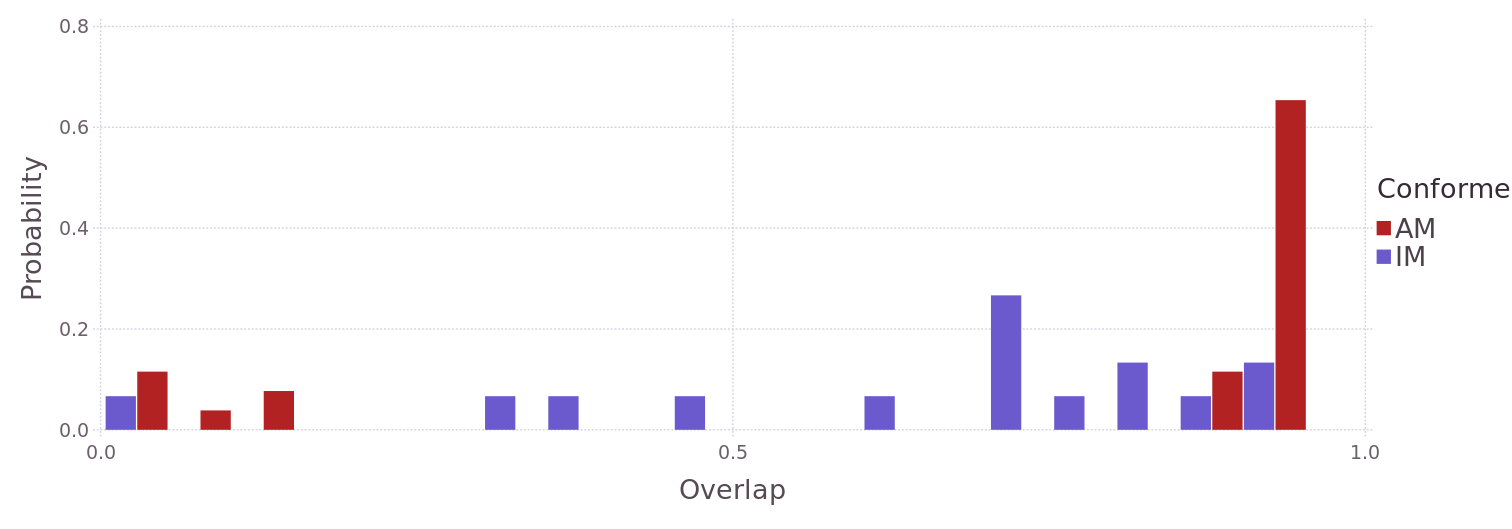

In [100]:
pdf_dots_svd_1 = plot(df_dots_svd_1, x="Overlap", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

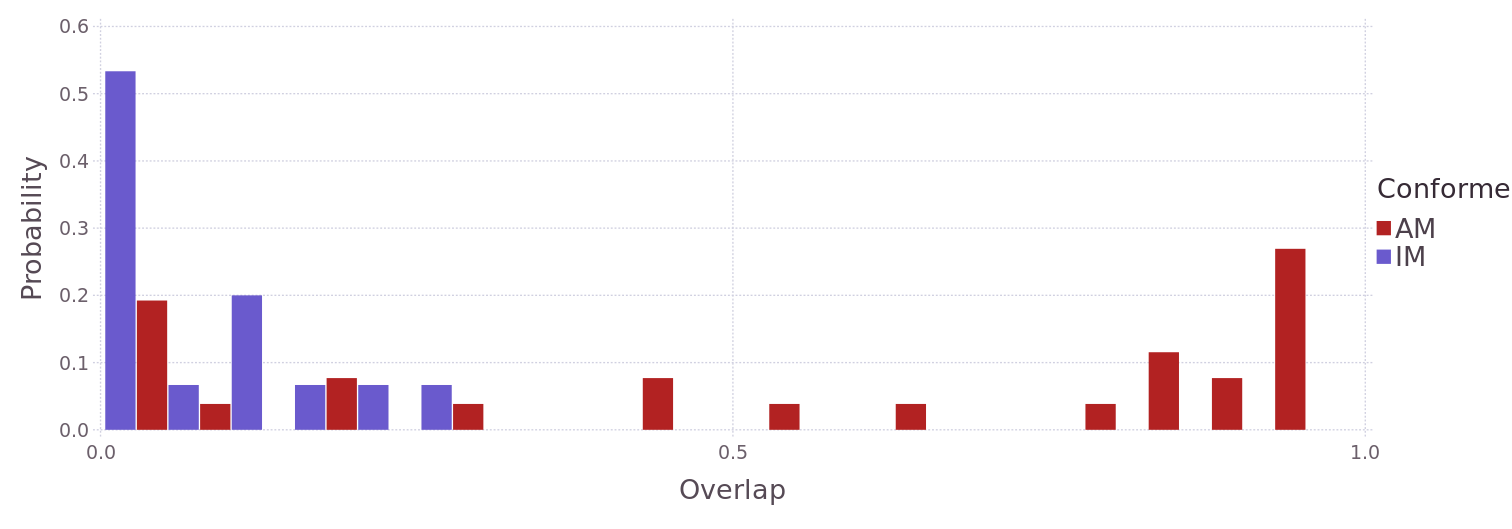

In [101]:
pdf_dots_svd_2 = plot(df_dots_svd_2, x="Overlap", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

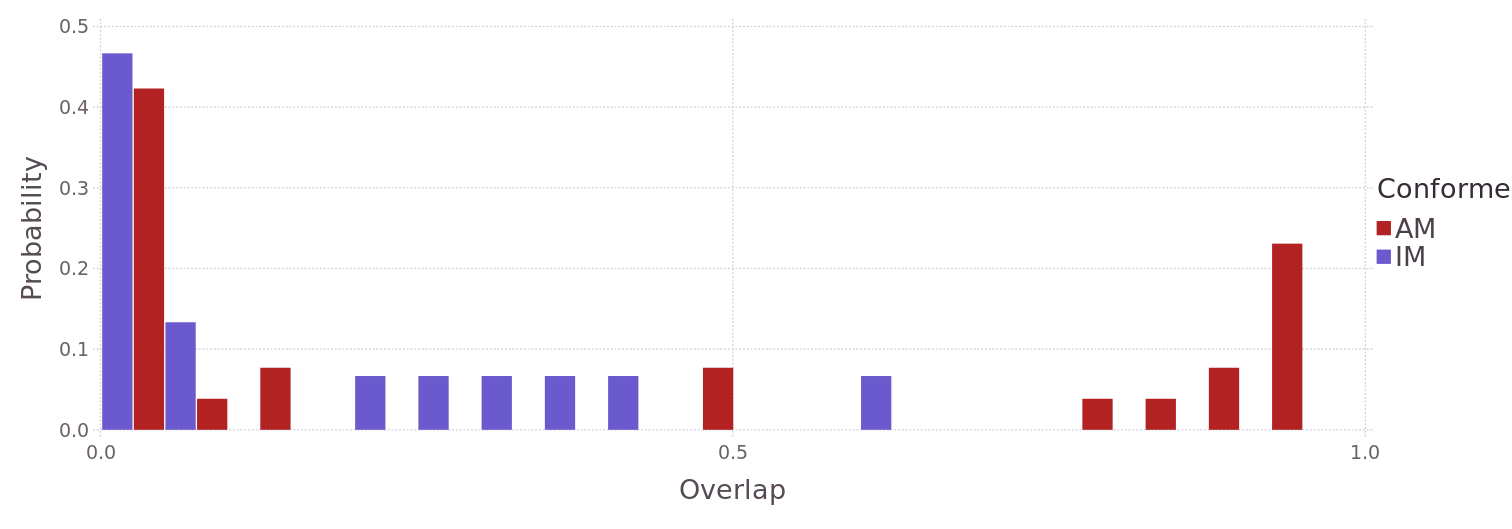

In [102]:
pdf_dots_svd_3 = plot(df_dots_svd_3, x="Overlap", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

## Guardo rtdos

In [113]:
# IM
writedlm(string(home_rtdos, "dots_svd_im_1"), dots_svd_im_1)
writedlm(string(home_rtdos, "dots_svd_im_1"), dots_svd_im_1)
writedlm(string(home_rtdos, "dots_svd_im_2"), dots_svd_im_2)
writedlm(string(home_rtdos, "dots_svd_im_3"), dots_svd_im_3)
writedlm(string(home_rtdos, "dots_svd_im_4"), dots_svd_im_4)
writedlm(string(home_rtdos, "dots_svd_im_5"), dots_svd_im_5)

# AM
writedlm(string(home_rtdos, "dots_svd_am_1"), dots_svd_am_1)
writedlm(string(home_rtdos, "dots_svd_am_1"), dots_svd_am_1)
writedlm(string(home_rtdos, "dots_svd_am_2"), dots_svd_am_2)
writedlm(string(home_rtdos, "dots_svd_am_3"), dots_svd_am_3)
writedlm(string(home_rtdos, "dots_svd_am_4"), dots_svd_am_4)
writedlm(string(home_rtdos, "dots_svd_am_5"), dots_svd_am_5)